# Speech Emotion Recognition Model CNN/LSTM - Part 2

## Overview of the Notebook

This notebook builds a **Convolutional Neural Network (CNN)** model for speech emotion recognition. The pipeline includes **data preparation, model training, evaluation**, and **saving the model and necessary preprocessing components** for future use.

#### Key Sections

1. **Data Loading and Preprocessing**
   - The dataset is loaded from a CSV file (`emotion.csv`), and any missing values are replaced with zero.
   - Feature (`X`) and target (`Y`) matrices are created, where `X` includes the feature columns and `Y` contains the emotion labels.
   - `Y` is one-hot encoded to accommodate the multiclass classification.
   - Data is split into training and testing sets, with a **20% test size**.


2. **Data Reshaping and Scaling**
   - Data is reshaped for compatibility with CNN and LSTM layers.
   - Features are scaled using **StandardScaler** for better training performance.


3. **Model Building**
   - The notebook defines a **CNN model** with several `Conv1D`, `BatchNormalization`, and `MaxPool1D` layers, along with `Dropout` layers to reduce overfitting.
   - The final layer uses a `softmax` activation function to classify the samples into multiple emotion classes.
   - Early stopping and learning rate reduction callbacks are applied to avoid overfitting and adjust the learning rate dynamically.


4. **Model Training**
   - The model is trained for **50 epochs** with a batch size of 64, using **categorical cross-entropy** as the loss function and **Adam** as the optimizer.
   - Training and validation accuracy and loss are plotted over epochs to visualize model performance.


5. **Model Evaluation**
   - The model’s accuracy on the test data is printed.
   - Predictions on test data are compared with actual labels, and a **confusion matrix** is plotted to evaluate the classification performance across each emotion class.
   - A **classification report** with precision, recall, and F1-score is generated.


6. **Model Saving and Reloading**
   - The trained model architecture and weights are saved in JSON and HDF5 formats.
   - The StandardScaler and the one-hot encoder are also saved using **pickle**, allowing consistent preprocessing when using the model in production.


#### Final Outputs
- **Confusion Matrix**: Visualizes the model's performance for each emotion.
- **Classification Report**: Summarizes the precision, recall, and F1-score for each emotion class.
- **Saved Model and Preprocessing Artifacts**: Ensures that the trained model can be loaded and used for predictions with the same preprocessing steps. 

This notebook is designed for users interested in building and evaluating a speech emotion recognition model, with considerations for real-world application deployment.

# Libraries Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Data Import

In [3]:
Emotions = pd.read_csv('/kaggle/input/speech-emotion-processed-dataset/emotion.csv')
Emotions

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.249512,0.371094,0.494629,0.487305,0.450195,0.416992,0.373047,0.337402,0.333496,0.333008,...,1.221636,1.231226,4.829375,-2.660280,-2.523232,0.690448,-3.171180,-4.200538,0.267294,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518293,0.838663,1.308726,1.855110,2.405185,2.896439,3.283485,3.541677,3.667470,surprise
3,0.257324,0.390625,0.510254,0.520020,0.499512,0.505859,0.493652,0.469238,0.480957,0.458496,...,-2.230192,0.787118,-3.272193,-2.678341,-4.033977,0.941363,3.609636,5.748407,5.765827,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48643,0.024902,0.041504,0.058105,0.056641,0.055664,0.051758,0.069336,0.099609,0.118652,0.122559,...,0.401646,-1.112955,5.011605,4.350423,-0.406691,-3.071908,3.590570,1.228106,4.510681,angry
48644,0.023926,0.035156,0.040527,0.035645,0.032715,0.029297,0.032715,0.048340,0.125488,0.214844,...,-6.260180,-3.632744,-8.042393,-2.985313,-3.020355,-11.220715,-7.787094,1.532857,0.766996,happy
48645,0.029785,0.083984,0.130371,0.162598,0.155762,0.110352,0.083496,0.094727,0.187012,0.276367,...,-6.400472,-10.313436,-7.786015,-5.070977,-3.618754,-4.733438,-4.008364,-2.504418,-1.294867,happy
48646,0.022461,0.034668,0.041992,0.038086,0.038086,0.034668,0.036133,0.044434,0.117676,0.208008,...,-4.223236,3.738558,-2.193993,1.545464,-3.276479,-17.348282,-1.698280,6.997660,-4.734335,happy


In [4]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [5]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [6]:
np.sum(Emotions.isna())

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

Data preparation

# Data Preprocessing

In [7]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions

X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [8]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [9]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [11]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [12]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

# Model Building

Applying early stopping for all models

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [14]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

## CNN Model

In [15]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [16]:
import tensorflow as tf

In [17]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary();

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,59

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

# Model Training

In [18]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50


I0000 00:00:1764101730.958865      98 service.cc:145] XLA service 0x7d4c40002fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764101730.958922      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/609 ━━━━━━━━━━━━━━━━━━━━ 2:36:56 15s/step - accuracy: 0.1250 - loss: 2.8401

I0000 00:00:1764101742.918698      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 104s 146ms/step - accuracy: 0.4038 - loss: 1.6494 - val_accuracy: 0.5025 - val_loss: 1.2821 - learning_rate: 0.0010
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.5598 - loss: 1.1342 - val_accuracy: 0.5939 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.6116 - loss: 1.0006 - val_accuracy: 0.6006 - val_loss: 1.0546 - learning_rate: 0.0010
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.6509 - loss: 0.9080 - val_accuracy: 0.6666 - val_loss: 0.8940 - learning_rate: 0.0010
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - accuracy: 0.7111 - loss: 0.7634 - val_accuracy: 0.6299 - val_loss: 1.0770 - learning_rate: 0.0010
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.7500 - loss: 0.6745 - val_accuracy: 0.7107 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.8097 - loss

# Model Evaluation

305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9812 - loss: 0.0808
Accuracy of our model on test data :  98.16032648086548 %


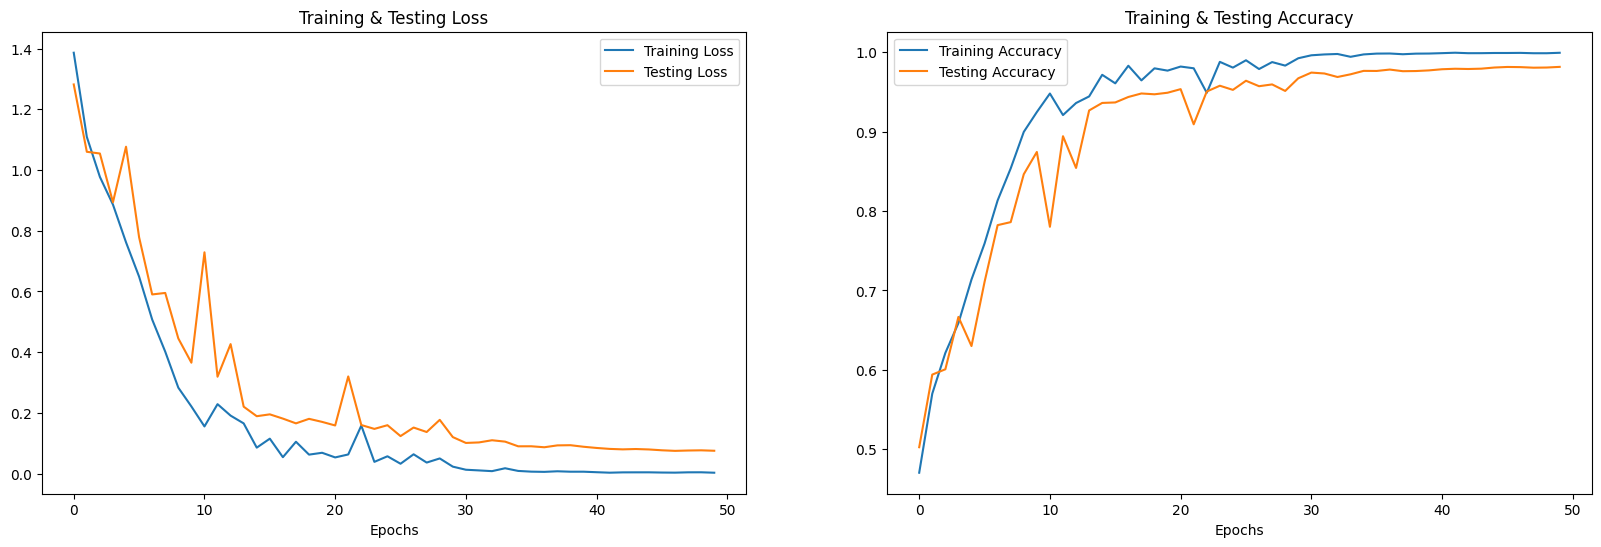

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


,Predicted Labels,Actual Labels
0,sad,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [21]:
df0

,Predicted Labels,Actual Labels
0,sad,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


Evalutation
Results of best model

In [22]:
import seaborn as sns

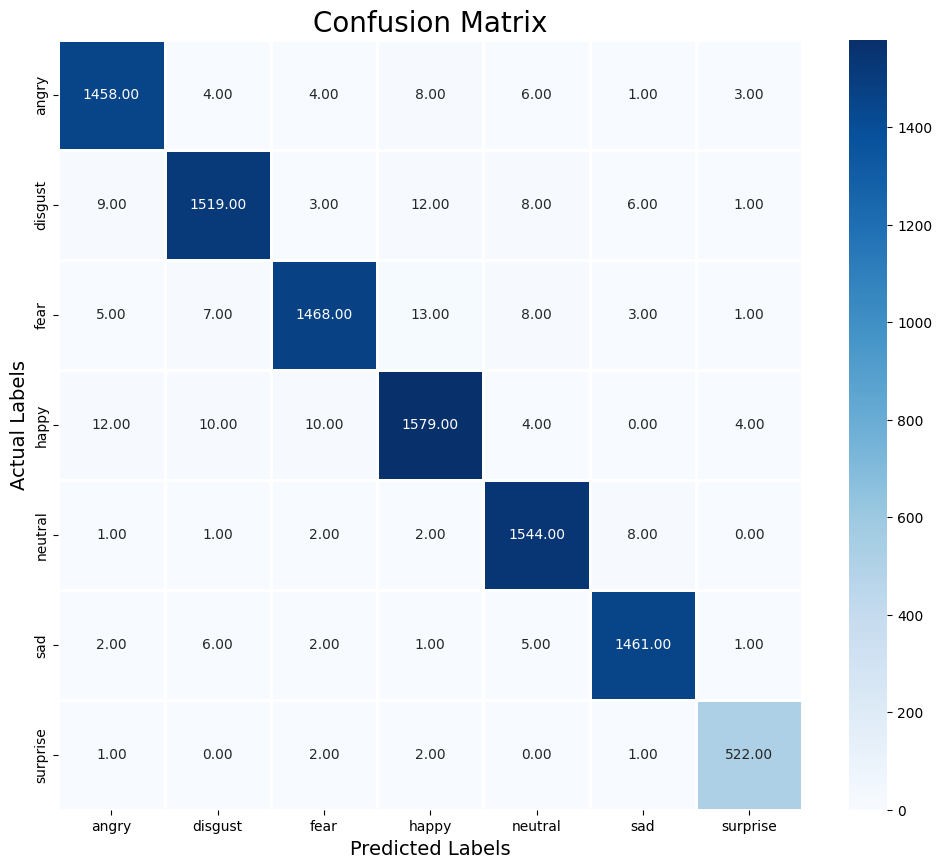

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1484
     disgust       0.98      0.97      0.98      1558
        fear       0.98      0.98      0.98      1505
       happy       0.98      0.98      0.98      1619
     neutral       0.98      0.99      0.99      1558
         sad       0.99      0.99      0.99      1478
    surprise       0.98      0.99      0.98       528

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730



In [23]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Model & Weights Saving

In [24]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [26]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9812 - loss: 0.0808
compile_metrics: 98.16%


## Saving the Standard Scaler and encoder

In [3]:
import pickle

# Saving scaler
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

NameError: name 'scaler' is not defined

# 












































































































































































































































































































































































Next Steps - Run Model from Saved Weight

This notebook [Speech Emotion Recognition Model CNN/LSTM | Part 3](https://www.kaggle.com/code/rikinzala/speech-emotion-recognition-model-cnn-lstm-part-3) will focus on evaluating the pre-trained model and making predictions using the saved weights and preprocessing components from the previous notebook. It builds upon the preprocessed and augmented data to assess the model's performance on new data.